# Laptop Price Prediction — Complete Colab Notebook
This notebook includes dummy Excel loading, EDA, preprocessing, model training, tuning, evaluation, and saving the model. It's ready to run in Google Colab.

**How to use:**
1. Upload `dummy_laptop_dataset.xlsx` when prompted (or place it in the Colab working directory).
2. Run cells from top to bottom.

In [1]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import joblib


## 1) Load dataset (Excel)
The cell below will try to read `dummy_laptop_dataset.xlsx`. If the file is not found it will open a file picker so you can upload it.

In [2]:
# Load Excel file (uploads if missing)
file_name = 'dummy_laptop_dataset.xlsx'
if not os.path.exists(file_name):
    from google.colab import files
    print(f"{file_name} not found — please upload it now.")
    uploaded = files.upload()
    # uploaded is a dict; the file will be saved into working directory automatically

df = pd.read_excel(file_name)
print('Loaded dataset with shape:', df.shape)
df.head()

dummy_laptop_dataset.xlsx not found — please upload it now.


Saving dummy_laptop_dataset.xlsx to dummy_laptop_dataset.xlsx
Loaded dataset with shape: (200, 17)


,buynow_price,graphic card type,communications,resolution (px),CPU cores,RAM size,operating system,drive type,input devices,multimedia,RAM type,CPU clock speed (GHz),CPU model,state,drive memory size (GB),warranty,screen size
0,1160,Dedicated,WiFi,1920x1080,6,16,Linux,HDD,KB+Touchpad,Stereo Speakers,DDR3,4.30,i5,Refurbished,512,24,15.6
1,1594,Integrated,WiFi+Bluetooth,1366x768,8,4,No OS,SSD,KB+Mouse,Stereo Speakers,DDR3,2.45,Ryzen 7,Used,128,0,14.0
2,1430,Integrated,WiFi,2560x1440,6,8,No OS,HDD,Keyboard,Basic,DDR3,3.02,Ryzen 3,Refurbished,1024,24,15.6
3,1395,NaN,WiFi,1366x768,6,8,Linux,SSD,KB+Mouse,Basic,DDR4,1.62,Ryzen 7,New,1024,6,15.6
4,1938,NaN,WiFi+Bluetooth,1366x768,2,32,No OS,NVMe,Keyboard,Stereo Speakers,DDR3,1.95,Ryzen 3,New,512,0,13.3


## 2) Quick EDA

In [3]:
# Basic info and stats
df.info()
print('\nMissing values per column:')
print(df.isna().sum())
print('\nNumeric summary:')
display(df.describe(include=[np.number]).T)
print('\nCategorical sample values:')
display(df.select_dtypes(include=['object']).nunique().sort_values(ascending=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   buynow_price            200 non-null    int64  
 1   graphic card type       138 non-null    object 
 2   communications          200 non-null    object 
 3   resolution (px)         200 non-null    object 
 4   CPU cores               200 non-null    int64  
 5   RAM size                200 non-null    int64  
 6   operating system        200 non-null    object 
 7   drive type              200 non-null    object 
 8   input devices           200 non-null    object 
 9   multimedia              200 non-null    object 
 10  RAM type                200 non-null    object 
 11  CPU clock speed (GHz)   200 non-null    float64
 12  CPU model               200 non-null    object 
 13  state                   200 non-null    object 
 14  drive memory size (GB)  200 non-null    in

,count,mean,std,min,25%,50%,75%,max
buynow_price,200.0,1487.3500,608.545971,301.00,978.0000,1547.50,1987.500,2498.0
CPU cores,200.0,4.8800,2.146775,2.00,4.0000,4.00,6.000,8.0
RAM size,200.0,14.3600,10.388939,4.00,4.0000,8.00,16.000,32.0
CPU clock speed (GHz),200.0,3.0167,0.847971,1.51,2.3075,3.09,3.635,4.5
drive memory size (GB),200.0,474.8800,341.823701,128.00,256.0000,256.00,512.000,1024.0
warranty,200.0,10.9800,9.242658,0.00,6.0000,6.00,24.000,24.0
screen size,200.0,15.1435,1.460797,13.30,14.0000,15.60,17.000,17.0



Categorical sample values:


,0
CPU model,6
operating system,4
input devices,3
communications,3
drive type,3
resolution (px),3
RAM type,3
multimedia,3
state,3
graphic card type,2


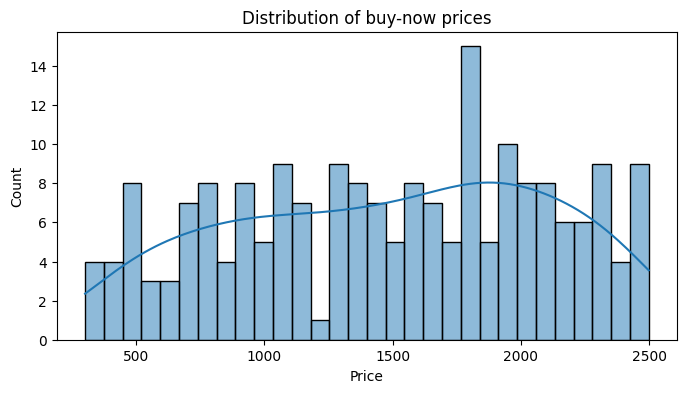

In [4]:
# Price distribution
plt.figure(figsize=(8,4))
sns.histplot(df['buynow_price'], bins=30, kde=True)
plt.title('Distribution of buy-now prices')
plt.xlabel('Price')
plt.show()

## 3) Train / Test split

In [5]:
# Features / target
X = df.drop(columns=['buynow_price'])
y = df['buynow_price']

# simple train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (160, 16) Test shape: (40, 16)


## 4) Preprocessing & ML pipeline
We OneHotEncode categorical features and pass numeric features through unchanged.

In [7]:
# Fix: convert numeric columns that appear as objects
numeric_fix_cols = [
    "resolution (px)",
    "CPU cores",
    "RAM size",
    "CPU clock speed (GHz)",
    "drive memory size (GB)",
    "screen size",
    "warranty"
]

for col in numeric_fix_cols:
    if col in X_train.columns:
        X_train[col] = pd.to_numeric(X_train[col], errors="coerce")
        X_test[col] = pd.to_numeric(X_test[col], errors="coerce")


In [8]:
# Identify categorical & numeric columns again after fixing dtypes
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

# Build preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ],
    remainder='drop'
)


Categorical columns: ['graphic card type', 'communications', 'operating system', 'drive type', 'input devices', 'multimedia', 'RAM type', 'CPU model', 'state']
Numeric columns: ['resolution (px)', 'CPU cores', 'RAM size', 'CPU clock speed (GHz)', 'drive memory size (GB)', 'warranty', 'screen size']


## 5) Train Random Forest as baseline

In [9]:
# Build pipeline with Random Forest
pipeline = Pipeline([
    ('pre', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])

pipeline.fit(X_train, y_train)
print('Model trained.')

Model trained.


## 6) Evaluate (RMSE)

In [11]:
# Predict and evaluate on test set
y_pred = pipeline.predict(X_test)

# Older sklearn version → no squared=False
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Test RMSE: {rmse:.2f}")


Test RMSE: 667.33


## 7) Optional: Hyperparameter tuning (GridSearchCV)
This cell runs a small grid search. It may take a few minutes depending on data and runtime.

In [12]:
from sklearn.model_selection import KFold

param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 12]
}

cv = KFold(n_splits=3, shuffle=True, random_state=42)
gs = GridSearchCV(pipeline, param_grid, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

print('Best params:', gs.best_params_)
best_model = gs.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'model__max_depth': 12, 'model__n_estimators': 200}


## 8) Feature importance (from the Random Forest in the final model)
We extract names of encoded features to map importances back to original features.

In [13]:
# Get feature importances from final model (best_model if GridSearch used, otherwise pipeline)
final = globals().get('best_model', pipeline)
rf = final.named_steps['model']

# Build feature name list from OneHotEncoder
ohe = final.named_steps['pre'].named_transformers_['cat']
if hasattr(ohe, 'get_feature_names_out'):
    cat_names = list(ohe.get_feature_names_out(categorical_cols))
else:
    # older sklearn fallback
    cat_names = []
numeric_names = numeric_cols
feature_names = cat_names + numeric_names

importances = rf.feature_importances_
fi = pd.DataFrame({'feature': feature_names, 'importance': importances})
fi = fi.sort_values('importance', ascending=False).reset_index(drop=True)
fi.head(20)

,feature,importance
0,CPU clock speed (GHz),0.188944
1,warranty,0.083884
2,drive memory size (GB),0.057803
3,CPU cores,0.053079
4,RAM size,0.043603
5,screen size,0.043386
6,drive type_NVMe,0.026409
7,multimedia_HD Webcam,0.024642
8,input devices_KB+Touchpad,0.023791
9,state_Used,0.022498


## 9) Save model to disk

In [14]:
# Save the final model to a file
out_name = 'laptop_price_model.joblib'
joblib.dump(final, out_name)
print('Saved model to', out_name)

# If running in Colab, provide download link
try:
    from google.colab import files
    files.download(out_name)
except Exception:
    pass


Saved model to laptop_price_model.joblib


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 10) Predict on a single example
Create a sample laptop dictionary and run prediction.

In [16]:
sample = {
    'graphic card type': 'Integrated',
    'communications': 'WiFi',
    'resolution (px)': 1920,          # FIXED (numeric)
    'CPU cores': 4,
    'RAM size': 8,
    'operating system': 'Windows 10',
    'drive type': 'SSD',
    'input devices': 'Keyboard',
    'multimedia': 'HD Webcam',
    'RAM type': 'DDR4',
    'CPU clock speed (GHz)': 2.6,
    'CPU model': 'i5',
    'state': 'Used',
    'drive memory size (GB)': 256,
    'warranty': 6,
    'screen size': 15.6
}
sample_df = pd.DataFrame([sample])
pred_price = final.predict(sample_df)[0]
print(f'Predicted buy-now price for sample: {pred_price:.2f}')

Predicted buy-now price for sample: 1547.51
